In [1]:
import xarray as xr
import earthkit.data
from earthkit.transforms import aggregate
from dask.distributed import LocalCluster

In [3]:
cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55387,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:55399,Total threads: 3
Dashboard: http://127.0.0.1:55403/status,Memory: 24.00 GiB
Nanny: tcp://127.0.0.1:55390,


In [3]:
pm_file = "./data/pm_final_srilanka_linearp.nc"
pm_ds = xr.open_dataset(pm_file, chunks={"time": 100})
pm_data = pm_ds["__xarray_dataarray_variable__"]

pop_file = "./data/lka_pop_2023_CN_1km_R2025A_UA_v1.tif"
pop_ds = xr.open_dataset(pop_file)
pop_data = pop_ds['band_data'].rename({"x": "lon", "y": "lat"})
pop_aligned = pop_data.interp(lon=pm_data.lon, lat=pm_data.lat, method="nearest")

pm_weighted = pm_data * pop_aligned

district_file = "./data/sri-lanka-provinces.geojson"
features = earthkit.data.from_source("file", district_file)

agg_num = aggregate.spatial.reduce(pm_weighted, features, how="sum", mask_dim="id")
agg_den = aggregate.spatial.reduce(pop_aligned, features, how="sum", mask_dim="id")

pw = agg_num / agg_den
pw.name = "pm25_popweighted"

agg_df = pw.to_dataframe().reset_index()

agg_df

,id,time,band,spatial_ref,pm25_popweighted
0,0,2020-03-01,1,0,38.548589
1,0,2020-03-02,1,0,53.535607
2,0,2020-03-03,1,0,66.601940
3,0,2020-03-04,1,0,43.020014
4,0,2020-03-05,1,0,35.567858
...,...,...,...,...,...
12604,8,2023-12-27,1,0,27.940178
12605,8,2023-12-28,1,0,24.785474
12606,8,2023-12-29,1,0,30.768315
12607,8,2023-12-30,1,0,28.500911


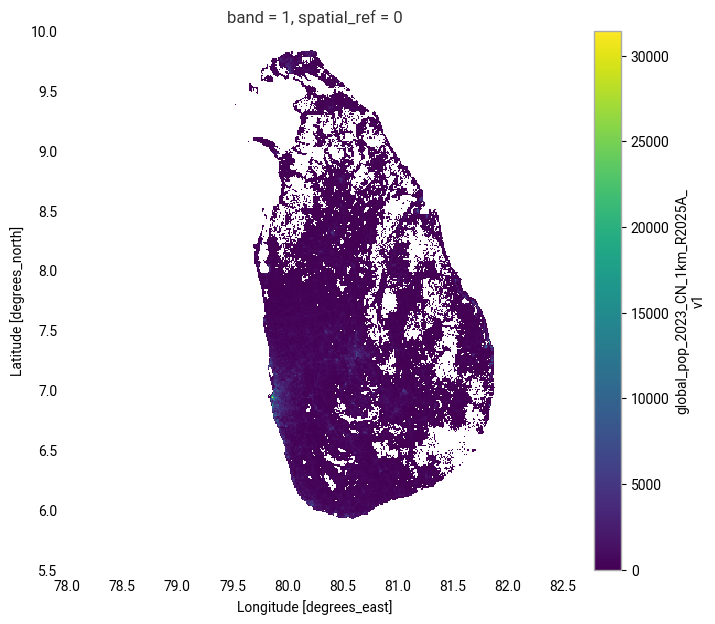

In [4]:
pop_aligned.plot()